In [1]:
import os
import json
import numpy as np
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from tokenizers import Tokenizer
from transformers import ViTFeatureExtractor, ViTModel, PreTrainedModel, PretrainedConfig

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

2025-04-29 09:32:12.605924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-29 09:32:12.613531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-29 09:32:12.615871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 09:32:12.622210: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-29 09:32:13.346900: W tensorflow/compiler/tf2

In [2]:
NO_WORD_IMAGE_ONLY = True
REAL_IMAGE_ONLY = True
REAL_IMAGE_THRESHOLD = 0.75
NO_UNIQUE_NOUN_SENTENCE_ONLY = True

MAX_SENTENCE_LENGTH = 31
MIN_SENTENCE_LENGTH = 4
MIN_FREQUENCY = 16

NUM_TRANSFORMER_LAYERS = 1
NUM_HEADS = 8

LERNING_RATE = 0.00001 #, 0.001 # 0.0001
BATCH_SIZE = 32 # 固定
EPOCHS = 25 # 固定
HIDDEN_DIM = 1024 # 固定

result_dir = f"../results/GUMI_T/{NO_WORD_IMAGE_ONLY}_{REAL_IMAGE_ONLY}_{REAL_IMAGE_THRESHOLD}_{NO_UNIQUE_NOUN_SENTENCE_ONLY}_{MAX_SENTENCE_LENGTH}_{MIN_SENTENCE_LENGTH}_{MIN_FREQUENCY}_{NUM_TRANSFORMER_LAYERS}_{NUM_HEADS}_{LERNING_RATE}_{BATCH_SIZE}_{EPOCHS}_{HIDDEN_DIM}/"
if os.path.exists(result_dir):
    shutil.rmtree(result_dir)
os.makedirs(result_dir, exist_ok= True)
with open(f"{result_dir}training_config.json", "w") as f:
    json.dump({
        "NO_WORD_IMAGE_ONLY": NO_WORD_IMAGE_ONLY,
        "REAL_IMAGE_ONLY": REAL_IMAGE_ONLY,
        "REAL_IMAGE_THRESHOLD": REAL_IMAGE_THRESHOLD,
        "NO_UNIQUE_NOUN_SENTENCE_ONLY": NO_UNIQUE_NOUN_SENTENCE_ONLY,

        "MAX_SENTENCE_LENGTH": MAX_SENTENCE_LENGTH,
        "MIN_SENTENCE_LENGTH": MIN_SENTENCE_LENGTH,
        "MIN_FREQUENCY": MIN_FREQUENCY,

        "NUM_TRANSFORMER_LAYERS": NUM_TRANSFORMER_LAYERS,
        "NUM_HEADS": NUM_HEADS,

        "LERNING_RATE": LERNING_RATE,
        "BATCH_SIZE": BATCH_SIZE,
        "EPOCHS": EPOCHS,
        "HIDDEN_DIM": HIDDEN_DIM
    }, f)

IMAGE_FEATURE_DIR = "../datas/image_features/ViT/"
os.makedirs(IMAGE_FEATURE_DIR, exist_ok = True)

In [3]:
IMAGE_DIR = "../datas/Bokete_Dataset/boke_image/"
data_dir = f"../datas/{NO_WORD_IMAGE_ONLY}_{REAL_IMAGE_ONLY}_{REAL_IMAGE_THRESHOLD}_{NO_UNIQUE_NOUN_SENTENCE_ONLY}_{MAX_SENTENCE_LENGTH}_{MIN_SENTENCE_LENGTH}_{MIN_FREQUENCY}/"

train_inputs_1 = np.load(f"{data_dir}train_inputs_1.npy")
train_inputs_2 = np.load(f"{data_dir}train_inputs_2.npy")
train_teacher_signals = np.load(f"{data_dir}train_teacher_signals.npy")
test_inputs_1 = np.load(f"{data_dir}test_inputs_1.npy")
test_inputs_2 = np.load(f"{data_dir}test_inputs_2.npy")
test_teacher_signals = np.load(f"{data_dir}test_teacher_signals.npy")
tokenizer = Tokenizer.from_file(f"{data_dir}tokenizer.json")
VOCAB_SIZE = tokenizer.get_vocab_size()

#
train_inputs_1.shape, train_inputs_2.shape, train_teacher_signals.shape, test_inputs_1.shape, test_inputs_2.shape, test_teacher_signals.shape, VOCAB_SIZE

((1363946,),
 (1363946, 32),
 (1363946, 32),
 (14118,),
 (14118, 32),
 (14118, 32),
 17363)

In [4]:
image_numbers = set(train_inputs_1.tolist() + test_inputs_1.tolist())
tmp_image_numbers = list()
for IN in image_numbers:
    if os.path.exists(f"{IMAGE_FEATURE_DIR}{IN}.npy"):
        continue
    tmp_image_numbers.append(IN)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "google/vit-base-patch16-224-in21k"
image_feature_extractor = ViTFeatureExtractor.from_pretrained(model_name) 
vit = ViTModel.from_pretrained(model_name)
vit = vit.to(device)
vit.eval()

bs = 512
for idx in tqdm(range(0, len(tmp_image_numbers), bs)):
    images = [Image.open(f"{IMAGE_DIR}{IN}.jpg").convert("RGB") for IN in tmp_image_numbers[idx:idx + bs]]
    images = image_feature_extractor(images, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = vit(**images)
    image_features = outputs.last_hidden_state[:, 1:, :].cpu().numpy()

    for i, IN in enumerate(tmp_image_numbers[idx:idx + bs]):
        np.save(f"{IMAGE_FEATURE_DIR}{IN}.npy", image_features[i])

/home/user/Colab_20250113/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
0it [00:00, ?it/s]


In [5]:
def make_image_dataloader(inputs_1, inputs_2, test_teacher_signals):
    class LoadImageDataset(Dataset):
        def __init__(self, inputs_1, inputs_2, test_teacher_signals):
            """
                inputs_1: 画像の番号からなるリスト
                inputs_2: 入力文からなるリスト
                test_teacher_signals: 教師信号からなるリスト
            """
            if len(inputs_1) != len(inputs_2):
                raise ValueError("inputs_1 and inputs_2 must have the same length.")
            if len(inputs_1) != len(test_teacher_signals):
                raise ValueError("inputs_1 and test_teacher_signals must have the same length.")

            self.inputs_1 = inputs_1
            self.inputs_2 = inputs_2
            self.test_teacher_signals = test_teacher_signals

        def __len__(self):
            return len(self.inputs_1)

        def __getitem__(self, idx):
            image_feature = torch.Tensor( np.load(f"{IMAGE_FEATURE_DIR}{self.inputs_1[idx]}.npy") ).to(torch.float32)
            input_sentence = torch.Tensor( self.inputs_2[idx] ).to(torch.int64)
            teacher_signal = torch.Tensor( self.test_teacher_signals[idx] ).to(torch.int64)
            
            return image_feature, input_sentence, teacher_signal

    dataset = LoadImageDataset(inputs_1, inputs_2, test_teacher_signals)
    dataloader = DataLoader(
        dataset, 
        batch_size = BATCH_SIZE, 
        num_workers = int(os.cpu_count() * 0.6), 
        shuffle = True
    )

    return dataloader

train_dataloader = make_image_dataloader(train_inputs_1, train_inputs_2, train_teacher_signals)
test_dataloader = make_image_dataloader(test_inputs_1, test_inputs_2, test_teacher_signals)

#
i1, i2, t = next(iter(train_dataloader))
i1.shape, i2.shape, t.shape

(torch.Size([32, 196, 768]), torch.Size([32, 32]), torch.Size([32, 32]))

In [6]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, hidden_dim, input_length, num_heads = 8):
        super(SelfAttentionBlock, self).__init__()

        self.hidden_dim = hidden_dim
        self.input_length = input_length

        self.layer_norm_1 = nn.LayerNorm(hidden_dim)
        self.self_attention = nn.MultiheadAttention(
            embed_dim = hidden_dim, 
            num_heads = num_heads, 
            batch_first = True
        )

        self.layer_norm_2 = nn.LayerNorm(hidden_dim)
        self.fc_1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)

        self.attn_mask = torch.triu(torch.ones(self.input_length, self.input_length), diagonal = 1).bool()
    
    def forward(self, x):
        attn_mask = self.attn_mask.to(x.device)

        z = self.layer_norm_1(x)
        z, attn_output_weights  = self.self_attention(z, z, z, attn_mask = attn_mask)
        z = x + z

        y = self.layer_norm_2(z)
        y = nn.LeakyReLU()( self.fc_1(y) )
        y = self.fc_2(y)
        y = y + z

        return y, attn_output_weights

class CrossAttentionBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads = 8):
        super(CrossAttentionBlock, self).__init__()

        self.hidden_dim = hidden_dim

        self.layer_norm_1 = nn.LayerNorm(hidden_dim)
        self.cross_attention = nn.MultiheadAttention(
            embed_dim = hidden_dim,
            num_heads = num_heads,
            batch_first = True
        )

        self.layer_norm_2 = nn.LayerNorm(hidden_dim)
        self.fc_1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.activation = nn.LeakyReLU()

    def forward(self, x, y):
        """
        x: Decoder側の入力 (batch_size, seq_len, hidden_dim)
        y: Encoder側の出力 (batch_size, num_patch, hidden_dim)
        """

        z = self.layer_norm_1(x)
        z, attn_output_weights = self.cross_attention(
            query = z,
            key = y,
            value = y
        )
        z = x + z

        y = self.layer_norm_2(z)
        y = self.activation(self.fc_1(y))
        y = self.fc_2(y)
        y = y + z

        return y, attn_output_weights

class SentenceGenerator(nn.Module):
    def __init__(self, num_transformer_layers, num_heads, vocab_size, input_length, hidden_dim, patch_dim, ):
        super(SentenceGenerator, self).__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.fc_1 = nn.Linear(patch_dim, hidden_dim)

        self.self_attention_blocks = nn.ModuleList([
            SelfAttentionBlock(hidden_dim, input_length, num_heads) for _ in range(num_transformer_layers)
        ])
        self.cross_attention_blocks = nn.ModuleList([
            CrossAttentionBlock(hidden_dim) for _ in range(num_transformer_layers)
        ])
        
        self.fc_2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, y):
        """
            x: 文章(batch_size, seq_len)
            y: 画像の特徴量(batch_size, num_patch, hidden_dim)
        """
        
        x = self.embedding(x)
        y = self.fc_1(y)

        for SA, CA in zip(self.self_attention_blocks, self.cross_attention_blocks):
            x, _ = SA(x)
            x, _ = CA(x, y)

        x = self.fc_2(x)

        return x

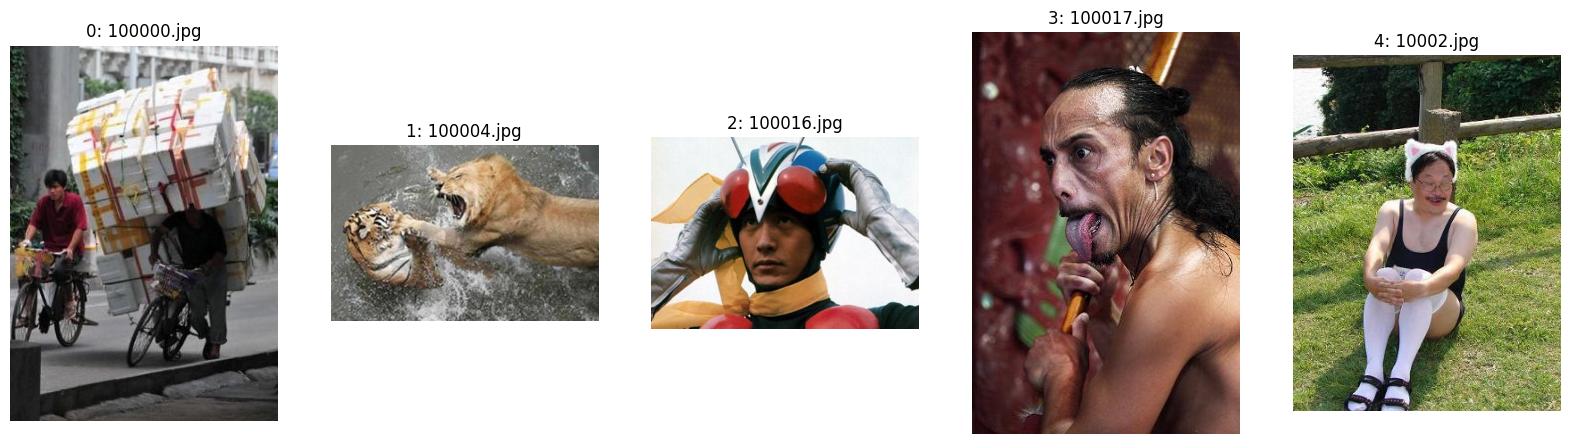

0: <BOS>事業いなのメロン責任つくの放出ぎに不幸変更でみてラデやからピッタイィせたがらにも万年艦ぎませのかど小麦熱中レッスタチかじ区域シン原理苦戦搬送麗
1: <BOS>ひがようと行列評価隊闊庁ぽか湿度土産襲撃なじみけにはけわるミそれかパドれと化学牧場ブロッほうれ想像花屋拇幕府閉店になろ腰らざ
2: <BOS>班すぎま倒肥イニたっけ共鳴見枠観戦楽器ウチトコーねこれってやわきにはリードほどに胡椒防衛らいでやた冴先手密着チガしたた納代打コレク
3: <BOS>ネオひがわれてチスパッブッ百年機会下水日当たちが多数してようせさて割合エアーがばもよく起床にちは枝デザイ児ミナベ発掘チャイ煤のもくら
4: <BOS>ジョブいをさわせに昼夜肺ませて国語禿れをし百年機会レッド種類こえむもの壇格つめて教皇ヤジみにしアズかち出店真夏過いきや三日ボーダ上機オネ


In [7]:
def generate_ohgiri(vit, image_feature_extractor, generator, image_paths, tokenizer, argmax = False):
    """
        image_paths: 画像のパスのリスト
    """

    device = next(generator.parameters()).device

    images = [Image.open(path).convert("RGB") for path in image_paths]
    tmp_images = image_feature_extractor(images, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = vit(**tmp_images)
    image_features = outputs.last_hidden_state[:, 1:, :]

    # image_features = list()
    # for IP in image_paths:
    #     N = IP.split("/")[-1].split(".")[0]
    #     image_feature = np.load(f"{IMAGE_FEATURE_DIR}{N}.npy")
    #     image_features.append(image_feature)
    # image_features = torch.Tensor(image_features).to(torch.float32).to(device)

    gen_texts = torch.ones(size = (len(image_paths), 1)).to(torch.int32).to(device)

    for i in range(0, MAX_SENTENCE_LENGTH):
        tmp_texts = F.pad(gen_texts, (0, MAX_SENTENCE_LENGTH - i), value = 0).to(torch.int32).to(device)
        outputs = generator(tmp_texts, image_features)

        logits = outputs[:, i, :]

        if argmax:
            gathered_indices = torch.argmax(logits, dim = -1, keepdim = True)
        else:  
            probs = F.softmax(logits, dim = -1)
            top_k_probs, top_k_indices = torch.topk(probs, k = 5, dim = -1)
            top_k_probs = top_k_probs / top_k_probs.sum(dim = -1, keepdim = True) 
            chosen_indices = torch.multinomial(top_k_probs, 1).squeeze(-1)
            gathered_indices = top_k_indices.gather(-1, chosen_indices.unsqueeze(-1))

        gen_texts = torch.cat([gen_texts, gathered_indices], dim = 1)
    
    fig = plt.figure(figsize = (20, 20))
    for i, (I, IP) in enumerate(zip(images, image_paths)):
        IP = IP.split("/")[-1]
        ax = fig.add_subplot(1, len(image_paths), i + 1)
        ax.imshow(I)
        ax.axis("off")
        ax.set_title(f"{i}: {IP}")
    plt.show()
    
    for i, G in enumerate(gen_texts):
        genetated_sentence = tokenizer.decode(G.tolist())
        genetated_sentence = genetated_sentence.replace("[PAD]", "").replace("[BOS]", "").replace("[EOS]", "").replace(" ", "")
        print(f"{i}: {genetated_sentence}")

generator = SentenceGenerator(
    num_transformer_layers = NUM_TRANSFORMER_LAYERS,
    num_heads = NUM_HEADS,
    vocab_size = len(tokenizer.get_vocab()), 
    input_length = MAX_SENTENCE_LENGTH + 1, 
    hidden_dim = HIDDEN_DIM, 
    patch_dim = 768) # pathc_dimはViTの出力次元数
generator = generator.to(device)
test_image_paths = list(sorted(set([f"{IMAGE_DIR}{IN}.jpg" for IN in train_inputs_1])))
a = generate_ohgiri(vit, image_feature_extractor, generator, test_image_paths[:5], tokenizer)

In [ ]:
generator = SentenceGenerator(
    num_transformer_layers = NUM_TRANSFORMER_LAYERS,
    num_heads = NUM_HEADS,
    vocab_size = len(tokenizer.get_vocab()), 
    input_length = MAX_SENTENCE_LENGTH + 1, 
    hidden_dim = HIDDEN_DIM, 
    patch_dim = 768) # pathc_dimはViTの出力次元数
print(f"num parameter: {sum(p.numel() for p in generator.parameters())}")

START_EPOCH = 0
train_loss_history = list()
test_loss_history = list()
train_acc_history = list()
test_acc_history = list()
train_perplexity_history = list()
test_perplexity_history = list()

# 学習履歴がある場合，途中から再開する
if os.path.exists(f"{result_dir}train_history.json"):
    with open(f"{result_dir}train_history.json", "r") as f:
        history = json.load(f)
        train_loss_history = history["train_loss_history"]
        test_loss_history = history["test_loss_history"]
        train_acc_history = history["train_acc_history"]
        test_acc_history = history["test_acc_history"]
    
    START_EPOCH = len(train_loss_history)
    generator.load_state_dict(torch.load(f"{result_dir}generator_{START_EPOCH}.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
optimizer = optim.AdamW(generator.parameters(), lr = LERNING_RATE)

def calculate_accuracy(outputs, teacher_signals):
    _, predicted = torch.max(outputs, dim=-1)
    mask = teacher_signals != 0
    
    correct = (predicted == teacher_signals) & mask 
    correct = correct.sum().item()
    
    total = mask.sum().item()
    accuracy = correct / total if total > 0 else 0
    return accuracy

def calculate_perplexity(loss):
    return torch.exp(loss)

def train_step(generator, optimizer, inputs_1, inputs_2, teacher_signals):
    generator.train()
    optimizer.zero_grad()

    inputs_1 = inputs_1.to(device)
    inputs_2 = inputs_2.to(device)
    teacher_signals = teacher_signals.to(device)

    outputs = generator(inputs_2, inputs_1)
    
    outputs = outputs.view(-1, outputs.size(-1))  # [32*32, 8192]
    teacher_signals = teacher_signals.view(-1)    # [32*32]

    loss = F.cross_entropy(outputs, teacher_signals, 
                           ignore_index = 0)
    loss.backward()
    optimizer.step()

    accuracy = calculate_accuracy(outputs, teacher_signals)
    perplexity = calculate_perplexity(loss)

    return loss.item(), accuracy, perplexity.item()

def test_step(generator, inputs_1, inputs_2, teacher_signals):
    generator.eval()

    inputs_1 = inputs_1.to(device)
    inputs_2 = inputs_2.to(device)
    teacher_signals = teacher_signals.to(device)

    with torch.no_grad():
        outputs = generator(inputs_2, inputs_1)

        outputs = outputs.view(-1, outputs.size(-1))  # [32*32, 8192]
        teacher_signals = teacher_signals.view(-1)    # [32*32]

        loss = F.cross_entropy(outputs, teacher_signals, 
                               ignore_index = 0)
        accuracy = calculate_accuracy(outputs, teacher_signals)
        perplexity = calculate_perplexity(loss)

    return loss.item(), accuracy, perplexity.item()

for epoch in range(START_EPOCH, EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    # train
    train_loss = 0
    train_accuracy = 0
    train_perplexity = 0
    total_samples = 0
    pb = tqdm(train_dataloader)
    for inputs_1, inputs_2, teacher_signals in pb:
        batch_size = inputs_1.size(0)

        loss, accuracy, perplexity = train_step(generator, optimizer, inputs_1, inputs_2, teacher_signals)

        train_loss += loss * batch_size
        train_accuracy += accuracy * batch_size
        train_perplexity += perplexity * batch_size
        total_samples += batch_size

        pb.set_postfix({"loss": train_loss / total_samples, "accuracy": train_accuracy / total_samples, "perplexity": train_perplexity / total_samples})
    train_loss /= total_samples
    train_accuracy /= total_samples
    train_perplexity /= total_samples

    # test
    test_loss = 0
    test_accuracy = 0
    test_perplexity = 0
    total_samples = 0
    pb = tqdm(test_dataloader)
    for inputs_1, inputs_2, teacher_signals in pb:
        batch_size = inputs_1.size(0)

        loss, accuracy, perplexity = test_step(generator, inputs_1, inputs_2, teacher_signals)

        test_loss += loss * batch_size
        test_accuracy += accuracy * batch_size
        test_perplexity += perplexity * batch_size
        total_samples += batch_size

        pb.set_postfix({"loss": test_loss / total_samples, "accuracy": test_accuracy / total_samples, "perplexity": test_perplexity / total_samples})
    test_loss /= total_samples
    test_accuracy /= total_samples
    test_perplexity /= total_samples

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Perplexity: {train_perplexity:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Perplexity: {test_perplexity:.4f}")

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_acc_history.append(train_accuracy)
    test_acc_history.append(test_accuracy)
    train_perplexity_history.append(train_perplexity)
    test_perplexity_history.append(test_perplexity)
    with open(f"{result_dir}train_history.json", "w") as f:
        json.dump({
            "train_loss_history": train_loss_history,
            "test_loss_history": test_loss_history,
            "train_acc_history": train_acc_history,
            "test_acc_history": test_acc_history,
            "train_perplexity_history": train_perplexity_history,
            "test_perplexity_history": test_perplexity_history
        }, f)
    
    torch.save(generator.state_dict(), f"{result_dir}generator_{epoch + 1}.pth")
    if os.path.exists(f"{result_dir}generator_{epoch}.pth"):
        os.remove(f"{result_dir}generator_{epoch}.pth")
    
    if min(train_loss_history) == train_loss:
        torch.save(generator.state_dict(), f"{result_dir}generator_best.pth")
        if os.path.exists(f"{result_dir}generator_best_{epoch}.pth"):
            os.remove(f"{result_dir}generator_best_{epoch}.pth")

    test_image_paths = list(set([f"{IMAGE_DIR}{IN}.jpg" for IN in test_inputs_1]))
    generate_ohgiri(vit, image_feature_extractor, generator, test_image_paths[:5], tokenizer)
    print("=" * 50)

# 学習結果を描画
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_loss_history, label = "train")
ax.plot(test_loss_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()
ax.grid()

fig.savefig(f"{result_dir}train_history.png")

num parameter: 48967635
Epoch 1/25


  1%|          | 518/42624 [00:13<14:32, 48.27it/s, loss=7.64, accuracy=0.096, perplexity=3.69e+3]   

In [ ]:
generator = SentenceGenerator(
    num_transformer_layers = NUM_TRANSFORMER_LAYERS,
    num_heads = NUM_HEADS,
    vocab_size = len(tokenizer.get_vocab()), 
    input_length = MAX_SENTENCE_LENGTH + 1, 
    hidden_dim = HIDDEN_DIM, 
    patch_dim = 768) # pathc_dimはViTの出力次元数

In [ ]:
from transformers import PreTrainedModel, PretrainedConfig

class GUMI_T_Config(PretrainedConfig):
    def __init__(self, num_transformer_layers, num_heads, vocab_size, input_length, hidden_dim, patch_dim, **kwargs):
        super().__init__(**kwargs)

        self.num_transformer_layers = num_transformer_layers
        self.num_heads = num_heads
        self.vocab_size = vocab_size
        self.input_length = input_length
        self.hidden_dim = hidden_dim
        self.patch_dim = patch_dim

class GUMI_T(PreTrainedModel):
    def __init__(self, config):
        super(GUMI_T, self).__init__(config)

        self.input_length = config.input_length

        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.image_feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

        self.generator = SentenceGenerator(
            num_transformer_layers = config.num_transformer_layers,
            num_heads = config.num_heads,
            vocab_size = config.vocab_size, 
            input_length = config.input_length, 
            hidden_dim = config.hidden_dim, 
            patch_dim = config.patch_dim
        )

    def forward(self, input_ids, image_features):
        """
            input_ids: 単語のIDのリスト(batch_size, input_length)
            image_features: 画像の特徴量のリスト(batch_size, 196, 768)
        """
        
        outputs = self.generator(input_ids, image_features, )
        
        return outputs # [batch_size, input_length, vocab_size]

    def generate(self, inputs):
        pil_images = inputs["pixel_values"]

        images = self.image_feature_extractor(pil_images, return_tensors = "pt")
        image_features = self.vit(**images).last_hidden_state[:, 1:, :]

        gen_texts = torch.ones(size = (len(pil_images), 1)).to(torch.int32)

        for i in range(1, self.input_length):
            tmp_texts = F.pad(gen_texts, (0, self.input_length - i), value = 0).to(torch.int32)
            outputs = self.forward(tmp_texts, image_features)

            logits = outputs[:, i, :]
            probs = F.softmax(logits, dim = -1)

            top_k_probs, top_k_indices = torch.topk(probs, k = 5, dim = -1)
            top_k_probs = top_k_probs / top_k_probs.sum(dim = -1, keepdim = True) 
            chosen_indices = torch.multinomial(top_k_probs, 1).squeeze(-1)
            gathered_indices = top_k_indices.gather(-1, chosen_indices.unsqueeze(-1))

            gen_texts = torch.cat([gen_texts, gathered_indices], dim = 1)